## **LightGBM**
LightGBM (Light Gradient Boosting Machine) is a high-performance, distributed gradient boosting framework developed by Microsoft. It is designed to be fast, memory-efficient, and scalable, making it well-suited for large datasets and high-dimensional features. Like XGBoost, it is based on gradient boosting decision trees but introduces optimizations to improve speed and reduce memory usage.

#### **How It Works**
1. *Gradient Boosting Framework* - Builds decision trees sequentially to minimize a loss function.
2. *Leaf-Wise Tree Growth* - Unlike traditional level-wise tree growth, LightGBM grows trees **leaf-wise with depth constraints**, leading to better accuracy
3. *Histogram-Based Splitting* - Continuous features are bucketed into discrete bins, reducing memory usage and speeding up training
4. *Parallel and GPU Learning* - Supports multi-core CPUs and GPU acceleration for faster computation

#### **Advantages**
- Extremely fast training due to histogram-based algorithm
- Memory-efficient with large datasets
- Supports categorical features directly (no need for one-hot encoding)
- High accuracy and strong generalization

#### **Limitations**
- More sensitive to hyperparameter tuning (especially with small datasets)
- Leaf-wise growth may lead to overfitting if not controlled with regularization
- Less interpretable compared to simpler models like Logistic Regression or single Decision Tree

### **Import necessary libraries**

In [1]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### **Prepare train, test data**

In [2]:
train_df = pd.read_csv('/kaggle/input/diabetes-dataset/train_data.csv')
test_df = pd.read_csv('/kaggle/input/diabetes-dataset/test_data.csv')

In [3]:
X_train = train_df.drop(columns=['diabetes'])
y_train = train_df['diabetes']
X_test = test_df.drop(columns=['diabetes'])
y_test = test_df['diabetes']

In [4]:
import re

def clean_col(col):
    return re.sub(r'[^A-Za-z0-9_]+', '_', col)

X_train = X_train.rename(columns=clean_col)
X_test = X_test.rename(columns=clean_col)

### **Initialize model**

In [5]:
model = LGBMClassifier()

In [6]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6800, number of negative: 73174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 79974, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085028 -> initscore=-2.375918
[LightGBM] [Info] Start training from score -2.375918


LGBMClassifier()

In [7]:
y_pred = model.predict(X_test)

In [8]:
y_pred

array([0, 0, 1, ..., 1, 0, 0])

Accuracy:  0.9719915974792438
Recall:  0.69
Precision:  0.972636815920398
F1 Score:  0.8072952512044046


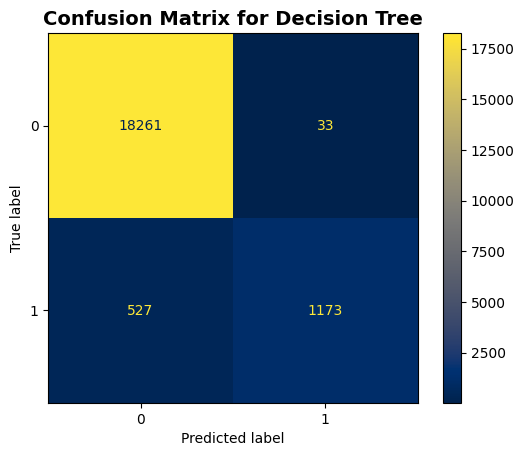

In [9]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for Decision Tree", fontsize=14, weight='bold')
plt.show()

### **Fine-tune hyperparameters**

In [10]:
finetuned_model = LGBMClassifier(random_state=42)

In [11]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "verbose": -1,
    }

    model = LGBMClassifier(
        **params,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="logloss",
    )

    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100000, timeout=39600)

print("Optuna Best Params:", study.best_trial.params)
print("Optuna Best Accuracy:", study.best_value)

Optuna Best Params: {'n_estimators': 1240, 'learning_rate': 0.013119868528607649, 'num_leaves': 84, 'max_depth': 3, 'subsample': 0.8596928193511121, 'colsample_bytree': 0.7037525824091245, 'reg_alpha': 0.8147709299386455, 'reg_lambda': 0.6537010254922306}
Optuna Best Accuracy: 0.9726417925377613


In [12]:
best_model = LGBMClassifier(
    **study.best_params,
    verbose=-1,
    random_state=42
)

In [13]:
best_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.7037525824091245,
               learning_rate=0.013119868528607649, max_depth=3,
               n_estimators=1240, num_leaves=84, random_state=42,
               reg_alpha=0.8147709299386455, reg_lambda=0.6537010254922306,
               subsample=0.8596928193511121, verbose=-1)

In [14]:
best_y_pred = best_model.predict(X_test)

Accuracy:  0.9726417925377613
Recall:  0.6876470588235294
Precision:  0.9864978902953586
F1 Score:  0.8103986135181975


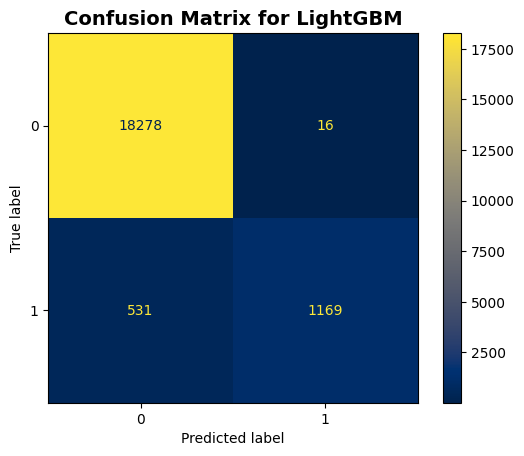

In [15]:
print("Accuracy: ", accuracy_score(y_test, best_y_pred))
print("Recall: ", recall_score(y_test, best_y_pred))
print("Precision: ", precision_score(y_test, best_y_pred))
print("F1 Score: ", f1_score(y_test, best_y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, best_y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for LightGBM", fontsize=14, weight='bold')
plt.show()

### **Save model**

In [16]:
import joblib
joblib.dump(best_model, "lgbm_model.pkl")

['lgbm_model.pkl']

### **Load model**

In [17]:
model = joblib.load("lgbm_model.pkl")

In [18]:
y_pred = model.predict(X_test)

Accuracy:  0.9726417925377613
Recall:  0.6876470588235294
Precision:  0.9864978902953586
F1 Score:  0.8103986135181975


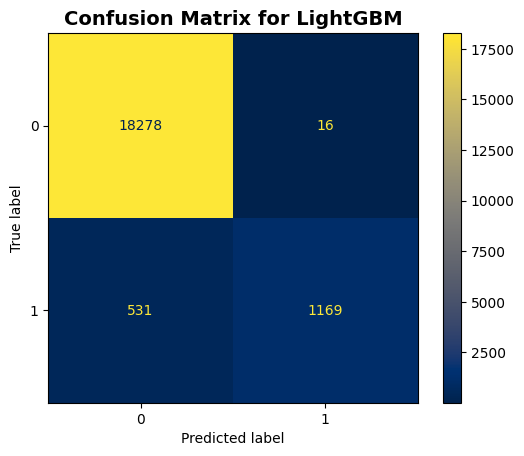

In [19]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for LightGBM", fontsize=14, weight='bold')
plt.show()